# IMPORTS

In [1]:
# Clone the Git repository and navigate to the project directory
!git clone https://github.com/DanteMillerDS/MPA_Predictor.git
%cd MPA_Predictor

# Install required packages
!pip install xgboost
!pip install pytorch-tabnet
!pip install torch

# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.io
import torch
import uuid
from sklearn.preprocessing import PowerTransformer
import torch
import xgboost as xgb
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import tensorflow as tf
from pytorch_tabnet.tab_model import TabNetRegressor
import keras
from sklearn.preprocessing import QuantileTransformer

# Set random seeds for reproducibility
np.random.seed(1000)
tf.random.set_seed(1000)

Cloning into 'MPA_Predictor'...
remote: Enumerating objects: 24, done.
remote: Counting objects: 100% (24/24), done.
remote: Compressing objects: 100% (21/21), done.
remote: Total 24 (delta 2), reused 13 (delta 0), pack-reused 0
Receiving objects: 100% (24/24), 4.59 MiB | 15.92 MiB/s, done.
Resolving deltas: 100% (2/2), done.
/content/MPA_Predictor
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 767.0 kB/s eta 0:00:00


# PREPROCESSING

In [2]:
file_paths = dict()
file_paths[0] = ["data/s11_dB_freq.txt"]

def process_file(file_path):
    datasets = []
    with open(file_path, 'r') as file:
        current_dataset = []
        for line in file:
            if line.startswith("#Parameters"):
                if current_dataset:
                    datasets.append(current_dataset)
                    current_dataset = []
                params_str = line[line.index("{") + 1:line.index("}")]
                params = dict(param.split('=') for param in params_str.split(';'))
                current_dataset.append(params)
            elif line.startswith("#"):
                continue
            else:
                data = line.strip().split('\t')
                current_dataset.append(data)
        if current_dataset:
            datasets.append(current_dataset)
    data = []
    for dataset in datasets:
        permittivity_values = dataset[0]
        df_data = dataset[1:]
        s_parameter_name = file_path.split("_parameter_data_for_")[0]
        df = pd.DataFrame(df_data, columns=["Frequency", f"{s_parameter_name}"])
        df["ID"] = str(uuid.uuid4())[:8]
        for key, value in permittivity_values.items():
            df[key.replace(" ", "")] = value
        data.append(df)
    return data
all_combined_data = []
for index in file_paths:
    for file in file_paths[index]:
        combined_data = process_file(file)
        combined_data = pd.concat(combined_data, ignore_index=True)
        all_combined_data.append(combined_data)
array = []
group_size = 4
for i in range(0, len(all_combined_data), group_size):
    combined_dataframe = pd.concat(all_combined_data[i:i+group_size], axis=1)
    combined_dataframe.reset_index(drop=True, inplace=True)
    array.append(combined_dataframe)
training_dataframe = pd.concat(array, axis=0)
training_dataframe.reset_index(drop=True, inplace=True)
training_dataframe = training_dataframe.loc[:, ~training_dataframe.columns.duplicated()]

In [3]:
print(training_dataframe.columns)

Index(['Frequency', 'data/s11_dB_freq.txt', 'ID', 'rprobe', 'rin', 'er22',
       'er2', 'cl', 'r0', 'w', 'L', 't', 'h', 'wy', 'wx', 'er11', 'er1'],
      dtype='object')


In [4]:
needed_columns = ["Frequency","data/s11_dB_freq.txt","h","t","er11","er1","w","L"]
training_dataframe = training_dataframe[needed_columns]

In [5]:
training_dataframe.columns = ["Frequency","Input_Impedance","Substrate_Thickness","Patch_Thickness","Permittivity_Imaginary","Permittivity_Real","Width","Length"]

In [6]:
training_dataframe.columns

Index(['Frequency', 'Input_Impedance', 'Substrate_Thickness',
       'Patch_Thickness', 'Permittivity_Imaginary', 'Permittivity_Real',
       'Width', 'Length'],
      dtype='object')

In [7]:
training_dataframe.dropna(inplace=True)
columns = training_dataframe.columns[1:]
training_dataframe[columns] = training_dataframe[columns].apply(pd.to_numeric)

In [8]:
training_dataframe.describe()

,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
count,100100.000000,1.001000e+05,1.001000e+05,1.001000e+05,1.001000e+05,100100.000000,100100.000000
mean,-3.252633,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,28.759751,46.015602
std,4.162713,2.220457e-16,2.775571e-17,1.734732e-18,4.440914e-16,13.298825,21.278120
min,-29.213769,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,5.535593,8.856949
25%,-4.395586,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,16.560724,26.497158
50%,-1.654782,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,29.681131,47.489809
75%,-0.417934,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,40.209226,64.334762
max,0.140660,1.600000e+00,2.000000e-01,1.000000e-02,2.550000e+00,48.676675,77.882680


In [9]:
training_dataframe.head(5)

,Frequency,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
0,1.0000000000000,-0.163918,1.6,0.2,0.01,2.55,41.662566,66.660105
1,1.0089999437332,-0.131358,1.6,0.2,0.01,2.55,41.662566,66.660105
2,1.0180000066757,-0.068440,1.6,0.2,0.01,2.55,41.662566,66.660105
3,1.0269999504089,-0.013418,1.6,0.2,0.01,2.55,41.662566,66.660105
4,1.0360000133514,-0.000152,1.6,0.2,0.01,2.55,41.662566,66.660105


In [10]:
lowest_impedance_rows = pd.DataFrame(columns=training_dataframe.columns)
for i in range(0,len(training_dataframe),1001):
  subset = training_dataframe[i:i+1001]
  min_impedance_row = subset[subset['Input_Impedance'] == subset['Input_Impedance'].min()]
  lowest_impedance_rows = pd.concat([lowest_impedance_rows, min_impedance_row])

In [11]:
lowest_impedance_rows

,Frequency,Input_Impedance,Substrate_Thickness,Patch_Thickness,Permittivity_Imaginary,Permittivity_Real,Width,Length
385,4.4650001525879,-20.224921,1.6,0.2,0.01,2.55,41.662566,66.660105
1344,4.0869998931885,-19.536557,1.6,0.2,0.01,2.55,45.760637,73.217019
2983,9.8290004730225,-24.501126,1.6,0.2,0.01,2.55,10.714407,17.143051
3343,4.0599999427795,-19.490123,1.6,0.2,0.01,2.55,46.101914,73.763062
4503,5.4910001754761,-23.453824,1.6,0.2,0.01,2.55,33.456166,53.529866
...,...,...,...,...,...,...,...,...
96065,9.7299995422363,-25.363050,1.6,0.2,0.01,2.55,10.845779,17.353247
96647,5.9590001106262,-25.414828,1.6,0.2,0.01,2.55,30.597065,48.955304
97751,6.8860001564026,-27.873510,1.6,0.2,0.01,2.55,26.122579,41.796126
98961,8.7670001983643,-17.926713,1.6,0.2,0.01,2.55,5.535593,8.856949


In [12]:
training_dataframe = lowest_impedance_rows

# DATA VISUALIZATION

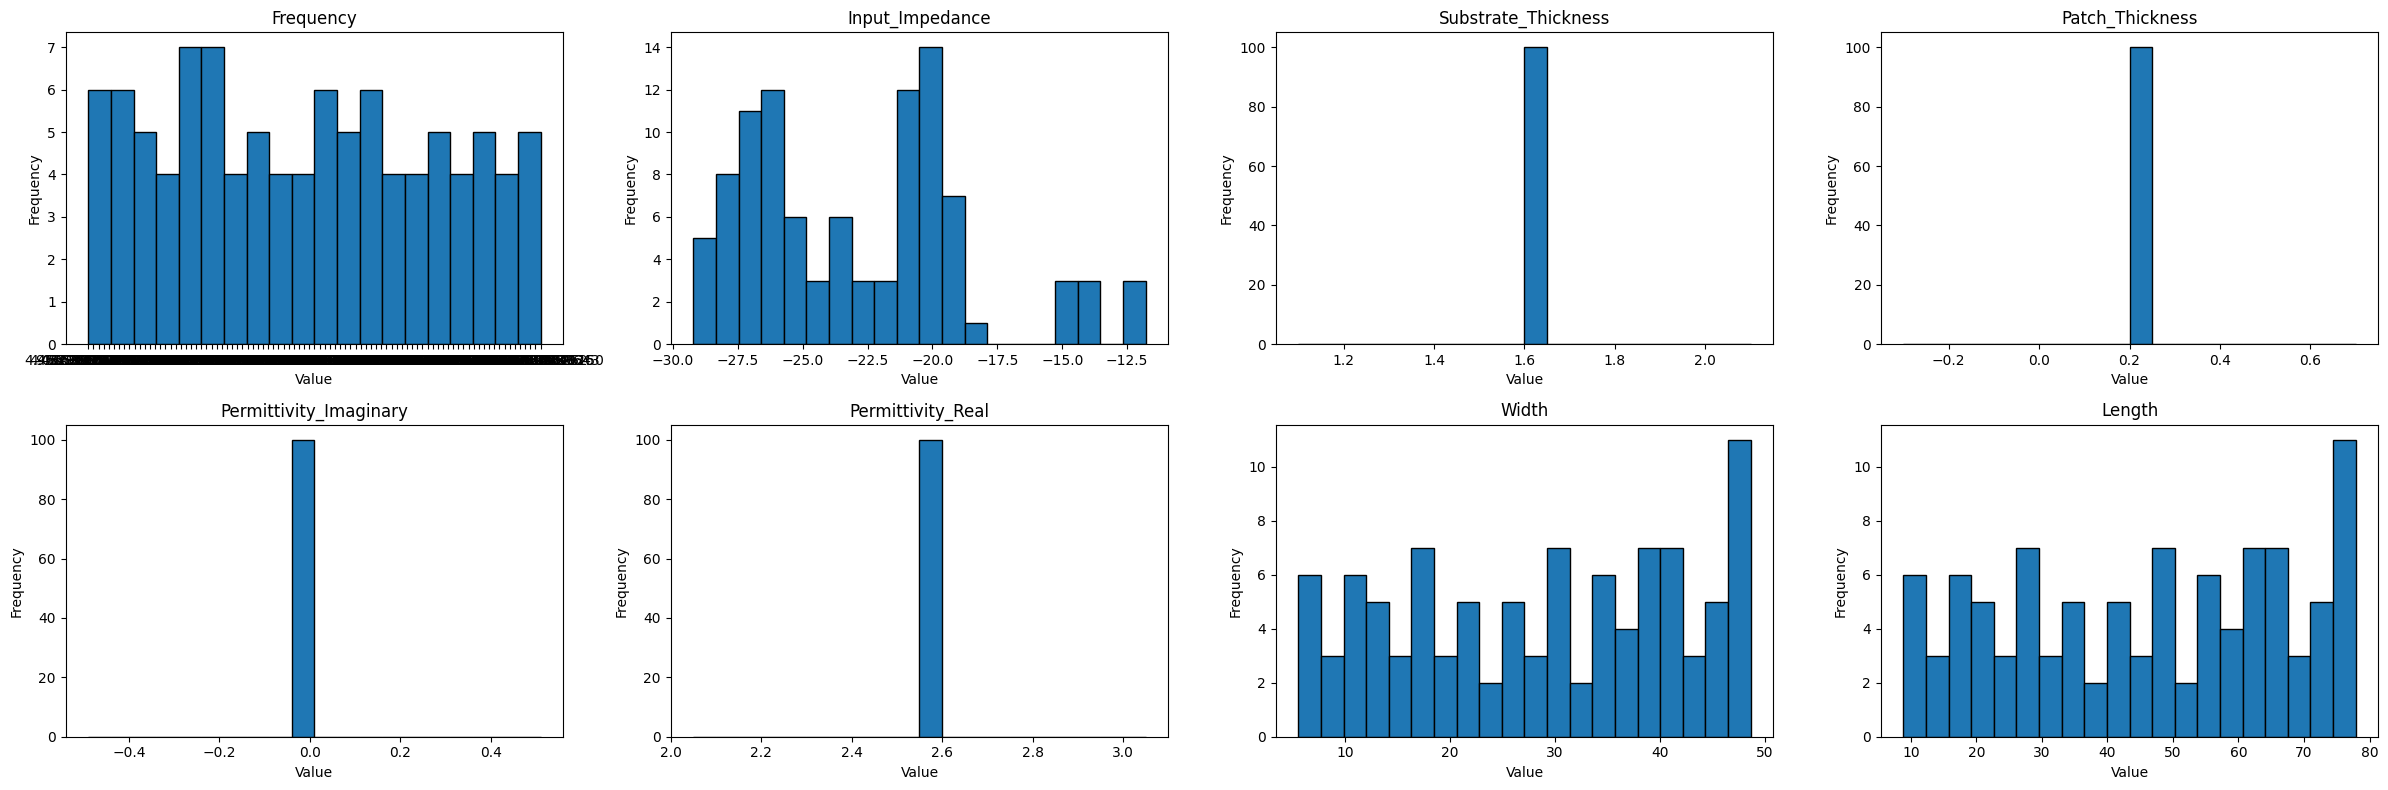

In [150]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,4 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

In [151]:
columns = ["Input_Impedance","Width","Length"]
training_mean_predicted_values = training_dataframe.groupby('Frequency')[columns].mean()

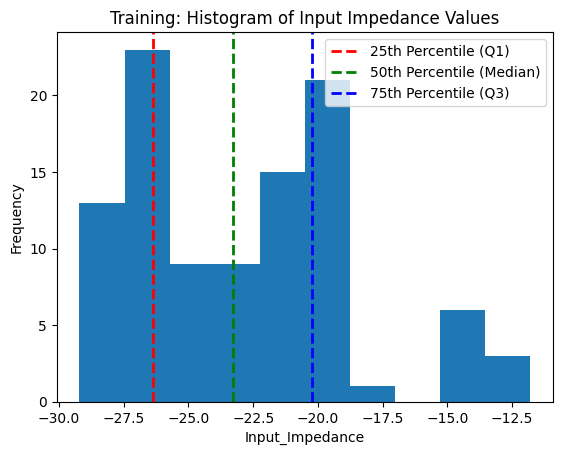

In [152]:
q25 = np.percentile(training_dataframe["Input_Impedance"], 25)
q50 = np.percentile(training_dataframe["Input_Impedance"], 50)
q75 = np.percentile(training_dataframe["Input_Impedance"], 75)
plt.hist(training_dataframe["Input_Impedance"])
plt.xlabel("Input_Impedance")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Input Impedance Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

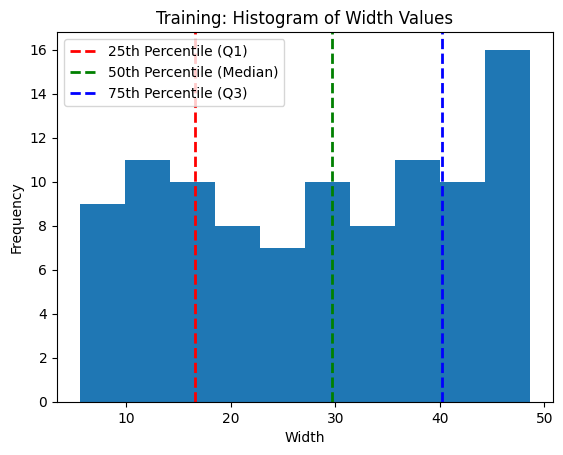

In [153]:
q25 = np.percentile(training_dataframe["Width"], 25)
q50 = np.percentile(training_dataframe["Width"], 50)
q75 = np.percentile(training_dataframe["Width"], 75)
plt.hist(training_dataframe["Width"])
plt.xlabel("Width")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Width Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

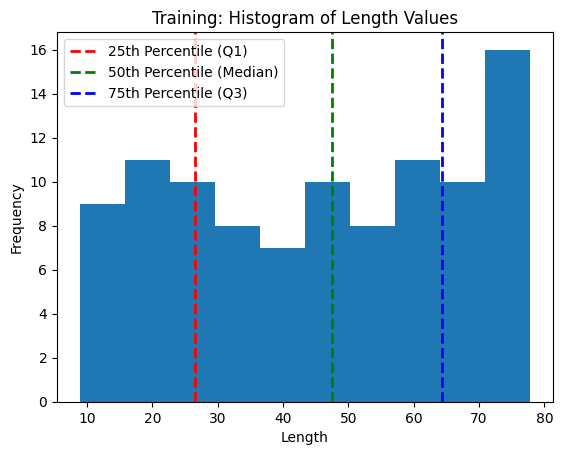

In [154]:
q25 = np.percentile(training_dataframe["Length"], 25)
q50 = np.percentile(training_dataframe["Length"], 50)
q75 = np.percentile(training_dataframe["Length"], 75)
plt.hist(training_dataframe["Length"])
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.title("Training: Histogram of Length Values")
plt.axvline(q25, color='red', linestyle='dashed', linewidth=2, label='25th Percentile (Q1)')
plt.axvline(q50, color='green', linestyle='dashed', linewidth=2, label='50th Percentile (Median)')
plt.axvline(q75, color='blue', linestyle='dashed', linewidth=2, label='75th Percentile (Q3)')
plt.legend()
plt.show()

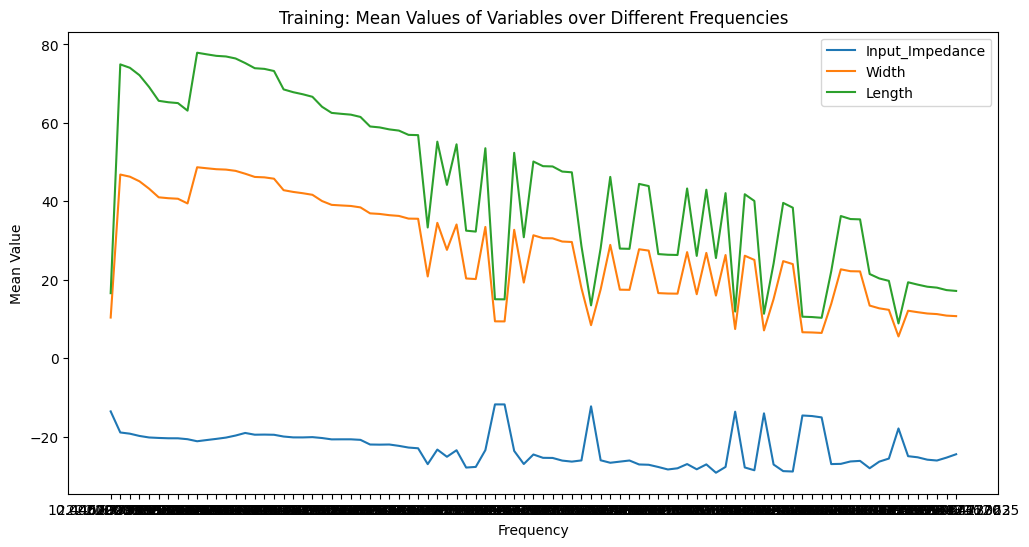

In [155]:
plt.figure(figsize=(12, 6))
for col in training_mean_predicted_values.columns:
    plt.plot(training_mean_predicted_values.index, training_mean_predicted_values[col], label=col)
plt.xlabel('Frequency')
plt.ylabel('Mean Value')
plt.title('Training: Mean Values of Variables over Different Frequencies')
plt.legend()
plt.show()

# WORK IN PROGRESS BELOW

# DATA MANIPULATION

In [122]:
training_dataframe["Permittivity_Real"] /= 100

In [123]:
training_dataframe["Substrate_Thickness"] /= 100

In [124]:
bc = PowerTransformer()
bc.fit(training_dataframe[["Input_Impedance","Width","Length"]])
training_dataframe[training_dataframe[["Input_Impedance","Width","Length"]].columns] = bc.transform(training_dataframe[["Input_Impedance","Width","Length"]])

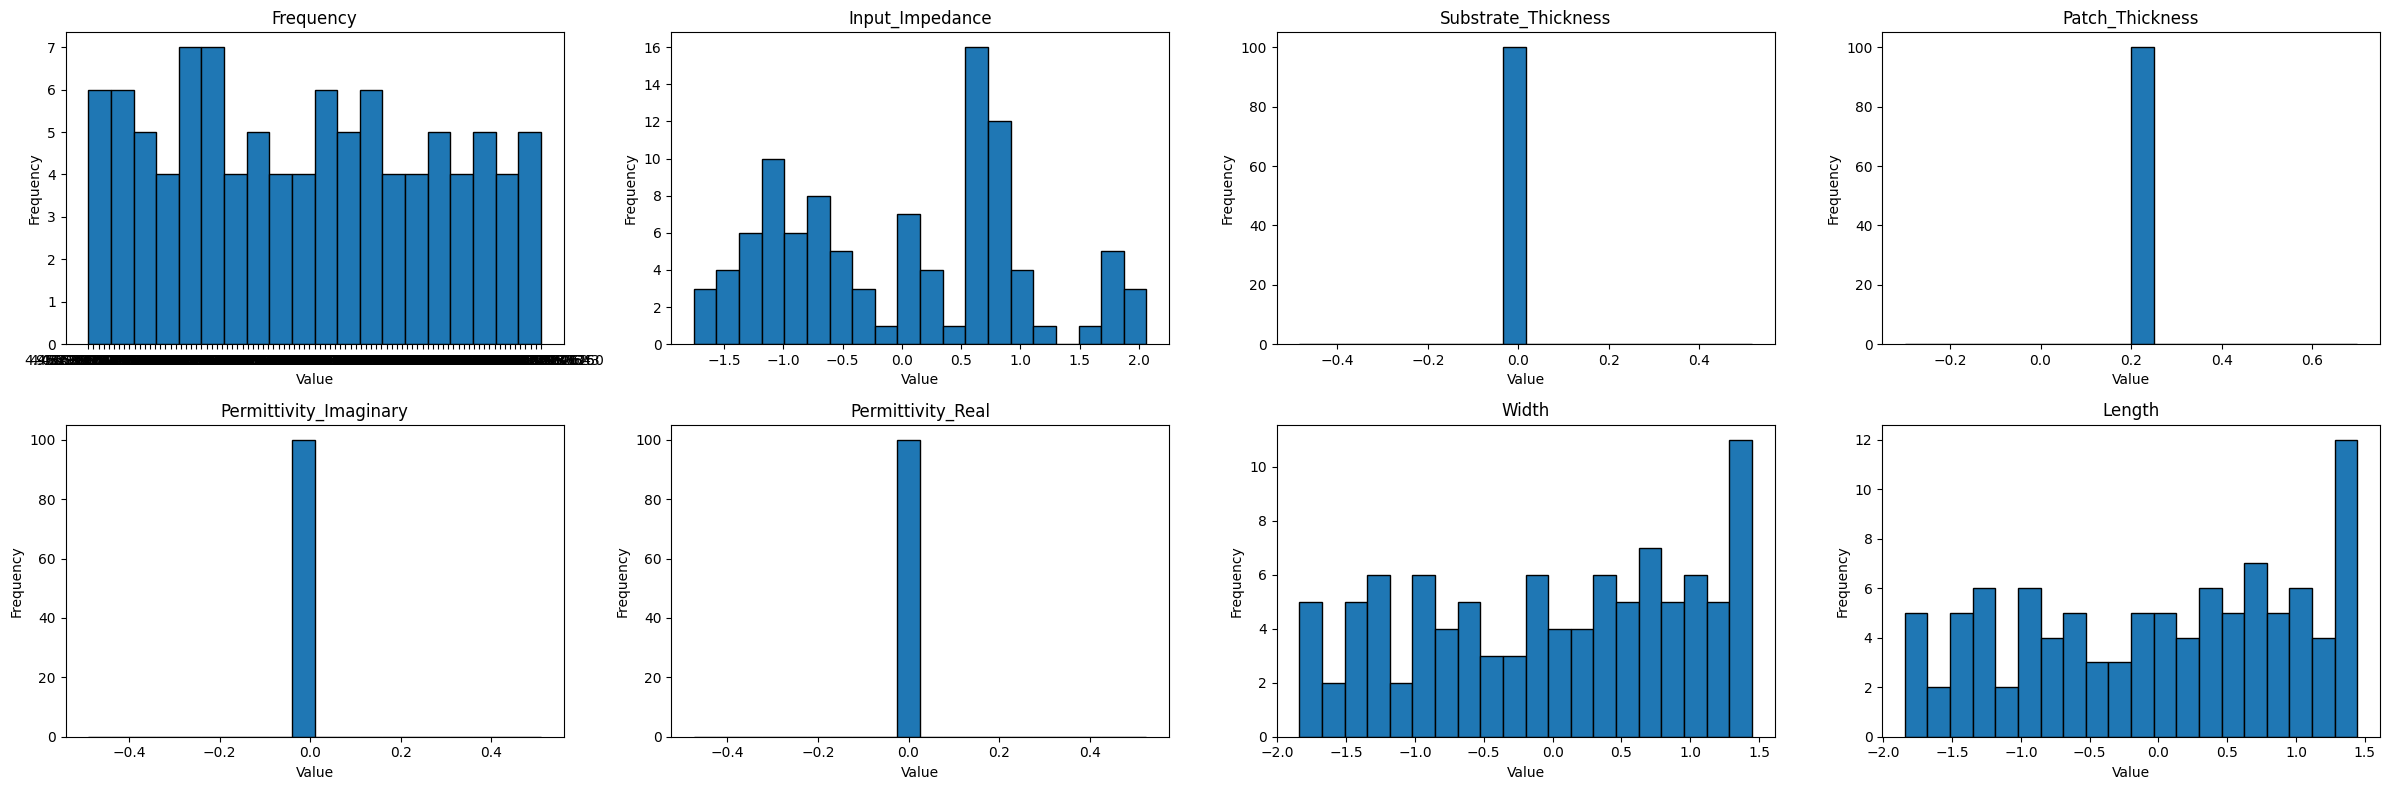

In [125]:
plt.figure(figsize=(24, 8))
for i, column in enumerate(training_dataframe.columns):
    plt.subplot(2,4 , i+1)
    plt.hist(training_dataframe[column], bins=20, edgecolor='black')
    plt.title(column)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
plt.tight_layout()
plt.show()

# MODELS

In [126]:
LR = 0.001
L2 = 0.0001
WD = 0.000001

In [127]:
columns = []
for column in training_dataframe.columns:
    if column not in ["Width","Length","Input_Impedance"]:
        columns.append(column)
columns

['Frequency',
 'Substrate_Thickness',
 'Patch_Thickness',
 'Permittivity_Imaginary',
 'Permittivity_Real']

In [128]:
X_train = training_dataframe[columns].values
y_train = training_dataframe[["Width","Length","Input_Impedance"]].values
selected_indices = np.random.permutation(len(training_dataframe))
X_selected = X_train[selected_indices]
y_selected = y_train[selected_indices]
# grouped_indices = {}
# for idx in selected_indices:
#     row = training_dataframe.iloc[idx]
#     frequency = row['Frequency']
#     key = (frequency)
#     if key not in grouped_indices:
#         grouped_indices[key] = []
#     grouped_indices[key].append(idx)
X_train_indices = []
X_val_indices = []
X_test_indices = []
# for key, indices in grouped_indices.items():
train_indices, val_indices = train_test_split(selected_indices, test_size=0.2, random_state=42)
val_indices, test_indices = train_test_split(val_indices, test_size=0.2, random_state=42)
X_train_indices.extend(train_indices)
X_val_indices.extend(val_indices)
X_test_indices.extend(test_indices)
X_train = X_selected[X_train_indices]
y_train = y_selected[X_train_indices]
X_val = X_selected[X_val_indices]
y_val = y_selected[X_val_indices]
X_test = X_selected[X_test_indices]
y_test = y_selected[X_test_indices]
X_train = X_train.astype(float)
y_train = y_train.astype(float)
X_val = X_val.astype(float)
y_val = y_val.astype(float)
X_test = X_test.astype(float)
y_test = y_test.astype(float)

In [129]:
num_obs_train = len(X_train)
num_obs_val = len(X_val)
num_obs_test = len(X_test)
total_obs = num_obs_train + num_obs_val + num_obs_test
data = {'Dataset': ['Training', 'Validation', 'Test', 'Total'],
        'Number of Observations': [num_obs_train, num_obs_val, num_obs_test, total_obs]}
observations_table = pd.DataFrame(data)
print(observations_table)

      Dataset  Number of Observations
0    Training                      80
1  Validation                      16
2        Test                       4
3       Total                     100


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_15 (Dense)            (None, 128)               768       
                                                                 
 dense_16 (Dense)            (None, 64)                8256      
                                                                 
 dense_17 (Dense)            (None, 32)                2080      
                                                                 
 dense_18 (Dense)            (None, 16)                528       
                                                                 
 dense_19 (Dense)            (None, 3)                 51        
                                                                 
Total params: 11683 (45.64 KB)
Trainable params: 11683 (45.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/50
3/3 [==

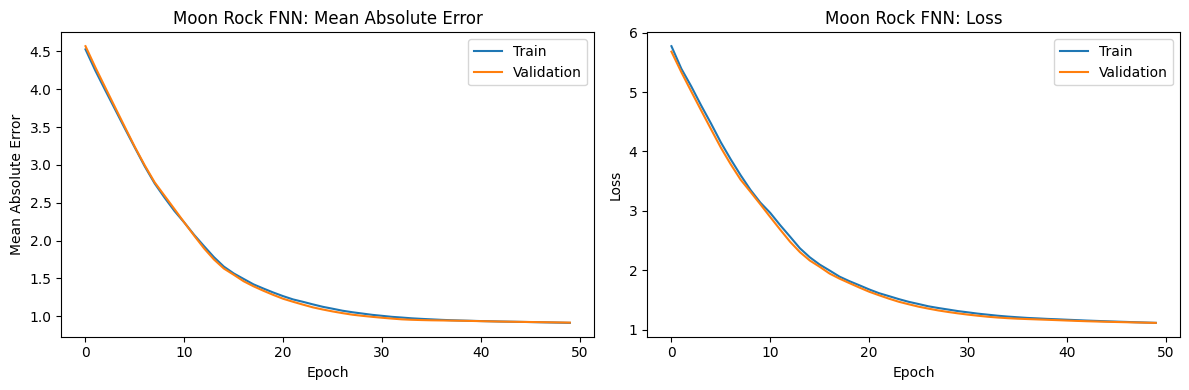

In [130]:
def rmse_loss(y_true, y_pred):
    squared_error = tf.square(y_true - y_pred)
    mean_squared_error = tf.reduce_mean(squared_error)
    root_mean_squared_error = tf.sqrt(mean_squared_error)
    return root_mean_squared_error

nn_model = keras.Sequential([
    keras.layers.Dense(128, activation='relu', input_shape=(X_train.shape[1],),kernel_initializer='he_uniform', kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(64, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(32, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(16, activation='relu', kernel_initializer='he_uniform',kernel_regularizer=tf.keras.regularizers.l2(L2)),
    keras.layers.Dense(y_train.shape[1], activation='linear')
])


nn_model.compile(optimizer=tf.optimizers.Adam(learning_rate=L2,weight_decay=WD),
              loss=[rmse_loss],
              metrics=[tf.metrics.MeanAbsoluteError(), tf.metrics.MeanSquaredError()])
nn_model.summary()
history = nn_model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=50,shuffle=True)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('Moon Rock FNN: Mean Absolute Error')
plt.xlabel('Epoch')
plt.ylabel('Mean Absolute Error')
plt.legend(['Train', 'Validation'])
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Moon Rock FNN: Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'])
plt.tight_layout()
plt.show()

In [131]:
xgb_model = xgb.XGBRegressor(n_jobs=-1,device="gpu",n_estimators=250,eval_metric=mean_absolute_error,verbosity=3,max_depth=5)
xgb_model.fit(X_train, y_train)

[00:42:11] ======== Monitor (0): HostSketchContainer ========
[00:42:11] AllReduce: 1.5e-05s, 1 calls @ 15us

[00:42:11] MakeCuts: 2.7e-05s, 1 calls @ 27us

[00:42:11] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0
[00:42:11] ======== Monitor (0): Learner ========
[00:42:11] Configure: 0.001277s, 1 calls @ 1277us

[00:42:11] EvalOneIter: 0.000463s, 250 calls @ 463us

[00:42:11] GetGradient: 0.000734s, 250 calls @ 734us

[00:42:11] PredictRaw: 0.000171s, 250 calls @ 171us

[00:42:11] UpdateOneIter: 0.050029s, 250 calls @ 50029us

[00:42:11] ======== Monitor (0): GBTree ========
[00:42:11] BoostNewTrees: 0.047165s, 250 calls @ 47165us

[00:42:11] CommitModel: 8.5e-05s, 250 calls @ 85us

[00:42:11] ======== Monitor (0): HistUpdater ========
[00:42:11] BuildHistogram: 0.005962s, 1292 calls @ 5962us

[00:42:11] EvaluateSplits: 0.011671s, 2042 calls @ 11671us

[00:42:11] InitData: 0.002374s, 750 calls @ 2374us

[00:42:11] InitRoot: 0.009732s, 750 calls @ 9732us

[00:42:11] Lea

/usr/local/lib/python3.10/dist-packages/xgboost/core.py:160: UserWarning: [00:42:11] WARNING: /workspace/src/context.cc:44: No visible GPU is found, setting device to CPU.
  warnings.warn(smsg, UserWarning)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device='gpu', early_stopping_rounds=None,
             enable_categorical=False,
             eval_metric=<function mean_absolute_error at 0x7958ddacd120>,
             feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=None, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=250,
             n_jobs=-1, num_parallel_tree=None, random_state=None, ...)

In [132]:
columns

['Frequency',
 'Substrate_Thickness',
 'Patch_Thickness',
 'Permittivity_Imaginary',
 'Permittivity_Real']

In [133]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32)
tabnet_model = TabNetRegressor(device_name = "cuda")
tabnet_model.fit(
    X_train, y_train,
    eval_set=[(X_val, y_val)],
    eval_metric=['rmse'],
    max_epochs=50,
)
# Plot the learning curves
# tabnet_model.plot_losses()

epoch 0  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 1  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 2  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 3  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 4  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 5  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 6  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 7  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 8  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 9  | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s
epoch 10 | loss: 0.0     | val_0_rmse: 2.51926 |  0:00:00s

Early stopping occurred at epoch 10 with best_epoch = 0 and best_val_0_rmse = 2.51926


/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")
/usr/local/lib/python3.10/dist-packages/pytorch_tabnet/callbacks.py:172: UserWarning: Best weights from best epoch are automatically used!
  warnings.warn(wrn_msg)


# EVALUATION

In [134]:
batch_size = 1
y_pred_nn = nn_model.predict(X_test)
y_pred_xgb = xgb_model.predict(X_test)
y_pred_tab = tabnet_model.predict(X_test)

y_pred_nn = y_pred_nn.reshape(-1, batch_size, y_pred_nn.shape[-1])
y_pred_xgb = y_pred_xgb.reshape(-1, batch_size, y_pred_xgb.shape[-1])
y_pred_tab = y_pred_tab.reshape(-1, batch_size, y_pred_tab.shape[-1])

y_pred_nn = np.mean(y_pred_nn, axis=1)
y_pred_xgb = np.mean(y_pred_xgb, axis=1)
y_pred_tab = np.mean(y_pred_tab, axis=1)

#y_test = np.mean(y_test, axis=1)

y_pred_0_nn, y_test_0 = y_pred_nn[:, 0], y_test[:, 0]
y_pred_1_nn, y_test_1 = y_pred_nn[:, 1], y_test[:, 1]
y_pred_2_nn, y_test_2 = y_pred_nn[:, 2], y_test[:, 2]

y_pred_0_xgb, _ = y_pred_xgb[:, 0], _
y_pred_1_xgb, _ = y_pred_xgb[:, 1], _
y_pred_2_xgb, _ = y_pred_xgb[:, 2], _
y_pred_0_tab, _ = y_pred_tab[:, 0], _
y_pred_1_tab, _ = y_pred_tab[:, 1], _
y_pred_2_tab, _ = y_pred_tab[:, 2], _

y_pred_0_nn = np.clip(y_pred_0_nn, 0.0, 0.2)
y_pred_1_nn = np.clip(y_pred_1_nn, 0.0, 0.2)
y_pred_2_nn = np.clip(y_pred_2_nn, 0.0, 0.2)
y_pred_0_xgb = np.clip(y_pred_0_xgb, 0.0, 0.2)
y_pred_1_xgb = np.clip(y_pred_1_xgb, 0.0, 0.2)
y_pred_2_xgb = np.clip(y_pred_2_xgb, 0.0, 0.2)
y_pred_0_tab = np.clip(y_pred_0_tab, 0.0, 0.2)
y_pred_1_tab = np.clip(y_pred_1_tab, 0.0, 0.2)
y_pred_2_tab = np.clip(y_pred_2_tab, 0.0, 0.2)

1/1 [==============================] - 1s 657ms/step
[00:42:22] DEBUG: /workspace/src/gbm/gbtree.cc:130: Using tree method: 0


In [ ]:
y_test_0 = np.mean(y_test_0.reshape(-1,batch_size),axis=1)
mse_xgb = mean_squared_error(y_test_0, y_pred_0_xgb)
mae_xgb = mean_absolute_error(y_test_0, y_pred_0_xgb)
r_squared_xgb = r2_score(y_test_0, y_pred_0_xgb)
mse_nn = mean_squared_error(y_test_0, y_pred_0_nn)
mae_nn = mean_absolute_error(y_test_0, y_pred_0_nn)
r_squared_nn = r2_score(y_test_0, y_pred_0_nn)
mse_tab = mean_squared_error(y_test_0, y_pred_0_tab)
mae_tab = mean_absolute_error(y_test_0, y_pred_0_tab)
r_squared_tab = r2_score(y_test_0, y_pred_0_tab)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"R-squared (R²): {r_squared_nn:.4f}")
print("\nMetrics for TabNet Model:")
print(f"MSE: {mse_tab:.4f}")
print(f"MAE: {mae_tab:.4f}")
print(f"R-squared (R²): {r_squared_tab:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_0)), y_test_0, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_nn, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot(range(len(y_test_0)), y_pred_0_tab, label='Predicted (TabNet)', color='green', alpha=0.7)
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_xgb), np.mean(y_pred_0_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_nn), np.mean(y_pred_0_nn)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.plot([0, len(y_test_0) - 1], [np.mean(y_pred_0_nn), np.mean(y_pred_0_nn)], linestyle='dashed', color='blue', label='Predicted Mean (TabNet)')
plt.title('Moon Rock: Simulated Actual and Predicted Real Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
y_test_1 = np.mean(y_test_1.reshape(-1, batch_size), axis=1)
mse_xgb = mean_squared_error(y_test_1, y_pred_1_xgb)
mae_xgb = mean_absolute_error(y_test_1, y_pred_1_xgb)
r_squared_xgb = r2_score(y_test_1, y_pred_1_xgb)
mse_nn = mean_squared_error(y_test_1, y_pred_1_nn)
mae_nn = mean_absolute_error(y_test_1, y_pred_1_nn)
r_squared_nn = r2_score(y_test_1, y_pred_1_nn)
mse_tab = mean_squared_error(y_test_1, y_pred_1_tab)
mae_tab = mean_absolute_error(y_test_1, y_pred_1_tab)
r_squared_tab = r2_score(y_test_1, y_pred_1_tab)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"R-squared (R²): {r_squared_nn:.4f}")
print("\nMetrics for TabNet Model:")
print(f"MSE: {mse_tab:.4f}")
print(f"MAE: {mae_tab:.4f}")
print(f"R-squared (R²): {r_squared_tab:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_1)), y_test_1, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_nn, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot(range(len(y_test_1)), y_pred_1_tab, label='Predicted (TabNet)', color='green', alpha=0.7)
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_xgb), np.mean(y_pred_1_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_nn), np.mean(y_pred_1_nn)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.plot([0, len(y_test_1) - 1], [np.mean(y_pred_1_nn), np.mean(y_pred_1_nn)], linestyle='dashed', color='BLUE', label='Predicted Mean (TabNet)')
plt.title('Moon Rock: Simulated Actual and Predicted Real Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()

In [ ]:
y_test_2 = np.mean(y_test_2.reshape(-1, batch_size), axis=1)
mse_xgb = mean_squared_error(y_test_2, y_pred_2_xgb)
mae_xgb = mean_absolute_error(y_test_2, y_pred_2_xgb)
r_squared_xgb = r2_score(y_test_2, y_pred_2_xgb)
mse_nn = mean_squared_error(y_test_2, y_pred_2_nn)
mae_nn = mean_absolute_error(y_test_2, y_pred_2_nn)
r_squared_nn = r2_score(y_test_2, y_pred_2_nn)
mse_tab = mean_squared_error(y_test_2, y_pred_2_tab)
mae_tab = mean_absolute_error(y_test_2, y_pred_2_tab)
r_squared_tab = r2_score(y_test_2, y_pred_2_tab)
print("Metrics for XGBoost Model:")
print(f"MSE: {mse_xgb:.4f}")
print(f"MAE: {mae_xgb:.4f}")
print(f"R-squared (R²): {r_squared_xgb:.4f}")
print("\nMetrics for FNN Model:")
print(f"MSE: {mse_nn:.4f}")
print(f"MAE: {mae_nn:.4f}")
print(f"R-squared (R²): {r_squared_nn:.4f}")
print("\nMetrics for TabNet Model:")
print(f"MSE: {mse_tab:.4f}")
print(f"MAE: {mae_tab:.4f}")
print(f"R-squared (R²): {r_squared_tab:.4f}")

plt.figure(figsize=(6, 4))
plt.plot(range(len(y_test_2)), y_test_2, label='Actual', color='blue', alpha=0.7)
plt.plot(range(len(y_test_2)), y_pred_2_xgb, label='Predicted (XGBoost)', color='green', alpha=0.7)
plt.plot(range(len(y_test_2)), y_pred_2_nn, label='Predicted (FNN)', color='purple', alpha=0.7)
plt.plot(range(len(y_test_2)), y_pred_2_tab, label='Predicted (TabNet)', color='green', alpha=0.7)
plt.plot([0, len(y_test_2) - 1], [np.mean(y_pred_2_xgb), np.mean(y_pred_2_xgb)], linestyle='dashed', color='red', label='Predicted Mean (XGBoost)')
plt.plot([0, len(y_test_2) - 1], [np.mean(y_pred_2_nn), np.mean(y_pred_2_nn)], linestyle='dashed', color='orange', label='Predicted Mean (FNN)')
plt.plot([0, len(y_test_2) - 1], [np.mean(y_pred_2_nn), np.mean(y_pred_2_nn)], linestyle='dashed', color='blue', label='Predicted Mean (TabNet)')
plt.title('Moon Rock: Simulated Actual and Predicted Real Permittivity')
plt.xlabel('Data Point')
plt.ylabel('Value')
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.show()